In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import cv2
import numpy as np
from PIL import Image
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Helpers

In [2]:
def yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape):
    """
    Convert YOLO bounding box predictions to bounding box coordinates (x_min,
    y_min, x_max, y_max)
    
    Parameters
    ----------
    box_xy: PyTorch tensor, box_xy output from YOLODetector, size: [1, 13, 13, 3, 2]
    box_wh: PyTorch tensor, box_wh output from YOLODetector, size: [1, 13, 13, 3, 2]
    input_shape: ? e.g. 416x416
    image_shape: ? e.g. 640x480
    """
    # [x, y] -> [y, x]
    box_yx = torch.stack((box_xy[..., 1], box_xy[..., 0]), dim=4)
    # [w, h] -> [h, w]
    box_hw = torch.stack((box_wh[..., 1], box_wh[..., 0]), dim=4)
    
    factor = torch.min((input_shape / image_shape))  # min(416./640., 416./480.)
    
    # New shape: round(640. * 416./640., 480. * 416./640.)
    new_shape = torch.round(image_shape * factor)
    
    # Compute offset: [0., (416.-312.)/(2*416.)] i.e. [0, 0.125]
    offset = (input_shape - new_shape) / (2. * input_shape)
    
    # Compute scale: [1., 416./312.] i.e. [1., 1.33]
    scale = input_shape / new_shape
    
    # Convert boxes from center (y,x) and (h, w) to (y_min, x_min) and (y_max, x_max)
    box_yx = (box_yx - offset) * scale  # [(x-0.)*1., (y-0.125)*1.33]
    box_hw = box_hw * scale  # [h*1, w*1.33]
    
    box_mins = box_yx - (box_hw / 2.)  # x_min = (x-0.)*1. - h/2, y_min = ...
    box_maxes = box_yx + (box_hw / 2.)  # x_max = (x-0.)*1. + h/2, y_max = ...
    
    # Stack box coordinates in proper order
    boxes = torch.stack([
        box_mins[..., 0], # y_min
        box_mins[..., 1], # x_min
        box_maxes[..., 0], # y_max
        box_maxes[..., 1], # x_max
    ], dim=4)  # size: [1, 13, 13, 3, 4]
    
    # Scale boxes back to original image shape
    boxes = boxes * torch.cat([image_shape, image_shape]).view(1, 1, 1, 1, 4)
    
    return boxes


def yolo_boxes_and_scores(feature_maps, anchors, n_classes, input_shape, image_shape):
    """
    Process output from YOLODetector
    
    Parameters
    ----------
    feature_maps: Feature maps learned by the YOLOv3 layer, shape = [1, 3*(5+C), 13, 13]
    anchors: Numpy array of shape = (3, 2). 3 anchors for each scale, and an anchor
        specifies its [width, height]. There are total 9 anchors, 3 for each scale.
    n_classes: int, number of classes
    input_shape: Pytorch tensor, that specifies (height, width). NOTE: height and width 
        are multiples of 32
    image_shape: Pytorch tensor. Original image shape
    
    Return
    ------
    """
    # Get output from YOLODetector
    box_xy, box_wh, box_confidence, box_class_probs = YOLODetector(feature_maps, anchors, n_classes, input_shape)
    
    # Correct the bounding boxes, size: [N, 13, 13, 3, 4] where 4 specifies y_min, x_min, y_max, x_max
    boxes = yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape)
    
    # Resize boxes tensor, size: [N, 13, 13, 3, 4] -> [13 * 13 * num_scales, 4]
    boxes = boxes.view([-1, 4])
    
    # Box scores = Box confidence * Box class probabilities
    box_scores = box_confidence * box_class_probs  # size: [N, 13, 13, 3, 4]
    box_scores = box_scores.view(-1, n_classes)  # size: [13 * 13 * num_scales, n_classes]
    
    return boxes.view(feature_maps.size(0), -1, 4), box_scores.view(feature_maps.size(0), -1, n_classes)

def non_maximum_suppression(boxes, thresh=0.3):
    """
    Reference: https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    
    Parameters
    ----------
    boxes: NumPy array, size: [?, 5], where ? can be some int, and 5 specifies 
        x_min, y_min, x_max, y_max
    thresh: float
    
    Return
    ------
    keep: list of indices of boxes to keep
    """
    # Get the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    scores = boxes[:, 4]  # Confidence scores
    
    # Compute area of each bounding box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    
    # Sort the bounding boxes by confidence score
    indices = scores.argsort()
    
    # Initialize a list for indices to keep
    keep = []
    
    while len(indices) > 0:
        
        # Grab the last index in the indices list and add the
        # index value to the keep list
        last = len(indices) - 1
        i = indices[last]
        keep.append(i)
        
        # Find the largest (x, y) coordinates for the start of the
        # bounding box and the smallest (x, y) coordinates for the
        # end of the bounding box
        xx1 = np.maximum(x1[i], x1[indices[:last]])
        yy1 = np.maximum(y1[i], y1[indices[:last]])
        xx2 = np.minimum(x2[i], x2[indices[:last]])
        yy2 = np.minimum(y2[i], y2[indices[:last]])
        
        # Compute the width and height of the bounding boxes
        w = np.maximum(0., xx2 - xx1 + 1)
        h = np.maximum(0., yy2 - yy1 + 1)
        
        # Compute the IoU
        inter_area = w * h
        iou = inter_area / (areas[i] + areas[indices[:last]] - inter_area)
        
        # Delete all the indices where 
        indices = np.delete(indices, np.concatenate(([last], np.where(iou > thresh)[0])))

    return keep

# Base (MobileNetV2)

In [3]:
## References
# 1. https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet_v2.py
# 2. https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
# 3. https://github.com/tonylins/pytorch-mobilenet-v2/blob/master/MobileNetV2.py

def _make_divisible(v, divisor, min_value=None):
    """
    This function makes sure that number of channels number is divisible by 8.
    Source: https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class ConvBnReLU(nn.Module):
    """
    [CONV]-[BN]-[ReLU6]
    """

    def __init__(self, inCh, outCh, stride):
        super(ConvBnReLU, self).__init__()
        self.inCh = inCh  # Number of input channels
        self.outCh = outCh  # Number of output channels
        self.stride = stride  # Stride
        self.conv = nn.Sequential(
            nn.Conv2d(self.inCh, self.outCh, 3, stride=self.stride, padding=1, bias=False),
            nn.BatchNorm2d(outCh),
            nn.ReLU6(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class InvertedResidual(nn.Module):
    """
    [CONV_1x1-BN-ReLU6]-[CONV_3x3-BN-ReLU6]-[CONV_1x1-BN] with identity shortcut.
    """

    def __init__(self, inCh, outCh, t, s):
        super(InvertedResidual, self).__init__()
        self.inCh = inCh
        self.outCh = outCh
        self.t = t  # t: expansion factor
        self.s = s  # s: Stride
        self.identity_shortcut = (self.inCh == self.outCh) and (self.s == 1)  # L:506 Keras official code

        # Bottleneck block
        self.block = nn.Sequential(
            # Expansition Conv
            nn.Conv2d(self.inCh, self.t * self.inCh, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(self.t * self.inCh),
            nn.ReLU6(inplace=True),

            # Depthwise Conv
            nn.Conv2d(self.t * self.inCh, self.t * self.inCh, kernel_size=3, stride=self.s, padding=1, groups=self.t * self.inCh,
                      bias=False),
            nn.BatchNorm2d(self.t * self.inCh),
            nn.ReLU6(inplace=True),

            # Pointwise Linear Conv (Projection): i.e. No non-linearity
            nn.Conv2d(self.t * self.inCh, self.outCh, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(self.outCh),
        )

    def forward(self, x):
        if self.identity_shortcut:
            return x + self.block(x)
        else:
            return self.block(x)


class PointwiseConv(nn.Module):
    def __init__(self, inCh, outCh):
        super(PointwiseConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(inCh, outCh, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(outCh),
            nn.ReLU6(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


# MobileNetV2
class MobileNetV2(nn.Module):
    """
    MobileNetV2 feature extractor for YOLOv3. NOTE: YOLOv3 uses convolutional layers only!

    Input: 416 x 416 x 3
    Last layer Pointwise conv output:13 x 13 x 1024 -> Large object detection
    5th layer Pointwise conv output: :26 x 26 x 512 -> Medium object detection
    3rd layer Pointwise conv output: 52 x 52 x 256 -> Small object detection
    """

    def __init__(self, params):
        super(MobileNetV2, self).__init__()
        self.params = params
        self.first_inCh = 3
        last_outCh = 1280

        self.c = [_make_divisible(c * self.params.alpha, 8) for c in self.params.c]
        # Last convolution has 1280 output channels for alpha <= 1
        self.last_outCh = _make_divisible(int(last_outCh * self.params.alpha),
                                          8) if self.params.alpha > 1.0 else last_outCh

        # NOTE: YOLOv3 makes predictions at 3 different scales: (1) In the last feature map layer: 13 x 13
        # (2) The feature map from 2 layers previous and upsample it by 2x: 26 x 26
        # (3) The feature map from 2 layers previous and upsample it by 2x: 52 x 52

        # Layer-0
        self.layer0 = nn.Sequential(ConvBnReLU(self.first_inCh, self.c[0], self.params.s[0]))

        # Layer-1
        self.layer1 = self._make_layer(self.c[0], self.c[1], self.params.t[1], self.params.s[1], self.params.n[1])

        # Layer-2
        self.layer2 = self._make_layer(self.c[1], self.c[2], self.params.t[2], self.params.s[2], self.params.n[2])

        # Layer-3
        self.layer3 = self._make_layer(self.c[2], self.c[3], self.params.t[3], self.params.s[3], self.params.n[3])
        self.layer3_out = nn.Sequential(PointwiseConv(self.c[3], 256))

        # Layer-4
        self.layer4 = self._make_layer(self.c[3], self.c[4], self.params.t[4], self.params.s[4], self.params.n[4])

        # Layer-5
        self.layer5 = self._make_layer(self.c[4], self.c[5], self.params.t[5], self.params.s[5], self.params.n[5])
        self.layer5_out = nn.Sequential(PointwiseConv(self.c[5], 512))

        # Layer-6
        self.layer6 = self._make_layer(self.c[5], self.c[6], self.params.t[6], self.params.s[6], self.params.n[6])

        # Layer-7
        self.layer7 = self._make_layer(self.c[6], self.c[7], self.params.t[7], self.params.s[7], self.params.n[7])

        # Layer-8
        self.layer8 = nn.Sequential(PointwiseConv(self.c[7], self.last_outCh))

        self.out_channels = [256, 512, 1280]
        
        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, inCh, outCh, t, s, n):
        layers = []
        for i in range(n):
            # First layer of each sequence has a stride s and all others use stride 1
            if i == 0:
                layers.append(InvertedResidual(inCh, outCh, t, s))
            else:
                layers.append(InvertedResidual(inCh, outCh, t, 1))

            # Update input channel for next IRB layer in the block
            inCh = outCh
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        out52 = self.layer3_out(x)
        x = self.layer4(x)
        x = self.layer5(x)
        out26 = self.layer5_out(x)
        x = self.layer6(x)
        x = self.layer7(x)
        out13 = self.layer8(x)
        return out52, out26, out13
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

# YOLO Detector

In [4]:
def YOLODetector(feature_maps, anchors, n_classes, input_shape, compute_loss=False):
    """
    Convert YOLOv3 layer feature maps to bounding box parameters.
    
    Reference: (1) https://github.com/qqwweee/keras-yolo3/blob/master/yolo3/model.py
               (2) https://github.com/jiasenlu/YOLOv3.pytorch/blob/master/misc/yolo.py
    
    Parameters
    ----------
    feature_maps: Feature maps learned by the YOLOv3 layer, shape = [1, 3*(5+C), 13, 13]
    anchors: Numpy array of shape = (3, 2). 3 anchors for each scale, and an anchor
        specifies its [width, height]. There are total 9 anchors, 3 for each scale.
    n_classes: int, number of classes
    input_shape: Pytorch tensor, that specifies (height, width). NOTE: height and width 
        are multiples of 32
    compute_loss: bool, if True then return outputs to calculate loss, else return
        predictions
    
    Return
    ------
    If compute loss is true then:
        grid (cell offsets), size: [1, 13, 13, 1, 2], where [..., 2:] is x,y center of cells
        feature_maps: Feature maps (raw predictions) learned by the YOLOv3 layer, size: [1, 13, 13, 3, 5+C]
        box_xy: Center (x, y) of bounding box, size: [1, 13, 13, 3, 2]
        box_wh: width, height of bounding box, size: [1, 13, 13, 3, 2]
    else:
        box_xy: Center (x, y) of bounding box, size: [1, 13, 13, 3, 2]
        box_wh: width, height of bounding box, size: [1, 13, 13, 3, 2]
        box_confidence: Confidence score, size: [1, 13, 13, 3, 1]
        box_class_probs: Class probabilities, size: [1, 13, 13, 3, C]
    """
    # NOTE: Comments are based on feature_maps of size [N, 3*(5+C), 13, 13] 
    if not compute_loss:
        feature_maps = feature_maps.cpu()
        input_shape = input_shape.cpu()
        
    # Number of anchors for each scale. It should be 3 anchors in each scale
    num_anchors = len(anchors)  # 3
    
    # Convert NumPy array to Torch tensor and reshape to include dimensions for (num_images, height, 
    # width, scales, 5+C), size: [3, 2] -> [1, 1, 1, 3, 2]
    anchors_tensor = torch.from_numpy(anchors).view(1, 1, 1, num_anchors, 2).type_as(feature_maps)
    
    # Compute grid shape
    grid_shape = feature_maps.shape[2:4]  # height x width
    
    # Create a grid or cell offsets
    grid_y = torch.arange(0, grid_shape[0])  # size: [13]
    grid_x = torch.arange(0, grid_shape[1])  # size: [13]

    grid_y = grid_y.view(-1, 1, 1, 1)  # size: [13] -> [13, 1, 1, 1]
    grid_x = grid_y.view(1, -1, 1, 1)  # size: [13] -> [1, 13, 1, 1]
    
    grid_y = grid_y.expand(grid_shape[0], grid_shape[0], 1, 1)  # size: [13, 1, 1, 1] -> [13, 13, 1, 1]
    grid_x = grid_x.expand(grid_shape[1], grid_shape[1], 1, 1)  # size: [1, 13, 1, 1] -> [13, 13, 1, 1]
    
    # Grid (x, y), where (x, y) is center of cell. Check `grid[0:2, ...]` output
    #  (0,0) (1,0) ... (12,0)
    #  (0,1) (1,1) ... ...
    #  ...         ... ...
    #  (0,12) ...  ... (12,12)
    grid = torch.cat([grid_x, grid_y], dim=3)  # size: [13, 13, 1, 2]
    
    # Insert one dimension for batch size
    grid = grid.unsqueeze(0).type_as(feature_maps)  # size: [13, 13, 1, 2] -> [1, 13, 13, 1, 2]
    
    # Reshape feature maps size: [1, 3*(5+C), 13, 13] -> [1, 13, 13, 3, 5+C]
    feature_maps = feature_maps.view(-1, num_anchors, 5 + n_classes, grid_shape[0], grid_shape[1])  # size: [1, 3*(5+C), 13, 13] -> [1, 3, 5+C, 13, 13]
    feature_maps = feature_maps.permute(0, 3, 4, 1, 2).contiguous()  # size: # [1, 3, 5+C, 13, 13] -> [1, 13, 13, 3, 5+C]
    
    # Compute: bx = sigmoid(tx) + cx and by = sigmoid(ty) + cy, output size: [1, 13, 13, 3, 2]
    box_xy = torch.sigmoid(feature_maps[..., :2]) + grid  # feature_maps[...,:2] -> xy
    
    # Compute: bw = pw * exp(tw) and bh = ph * exp(th), output size: [1, 13, 13, 3, 2]
    box_wh = anchors_tensor * torch.exp(feature_maps[..., 2:4])  # feature_maps[...,2:4] -> wh
    
    # Adjust predictions to each spatial grid point and anchor size
    # box_xy some values are > 1 so [sigmoid(tx) + cx]/13 and [sigmoid(ty) + cy]/13
    # makes box_xy values to be in range [0, 1]
    box_xy = box_xy / torch.tensor(grid_shape).view(1, 1, 1, 1, 2).type_as(feature_maps)
    
    # box_wh values needs to be scaled by input_shape
    box_wh = box_wh / input_shape.view(1, 1, 1, 1, 2)
    
    # Box confidence score, output size: [1, 13, 13, 3, 1]
    box_confidence = torch.sigmoid(feature_maps[..., 4:5]) # feature_maps[..., 4:5] -> confidence scores
    
    # Box class probabilities, output size: [1, 13, 13, 3, C]
    box_class_probs = torch.sigmoid(feature_maps[..., 5:]) # feature_maps[..., 5:] -> class scores
    
    if compute_loss:
        return grid, feature_maps, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs

# YOLO Loss

In [12]:
class YOLOLoss(nn.Module):
    """
    Reference: (1) https://github.com/qqwweee/keras-yolo3/blob/master/yolo3/model.py
               (2) https://github.com/jiasenlu/YOLOv3.pytorch/blob/master/misc/yolo.py
    """
    def __init__(self, params):
        super(YOLOLoss, self).__init__()
        self.params = params
        self.anchors = np.array(params.anchors)
        self.num_scales = len(self.anchors) // 3
        self.anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
        self.n_classes = len(params.class_names)
        self.ignore_thresh = 0.5
        
        # Losses: Mean Squared Error and Binary Cross Entropy
        self.mse_loss = nn.MSELoss(reduction='none')
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')
        
    def forward(self, yolo_outputs, y_true):
        """
        Parameters
        ----------
        yolo_outputs: list of Pytorch Tensors (YOLO network output. Where tensors 
            shapes are [(N, 3 * (5 + C), 13, 13), (N, 3 * (5 + C), 26, 26), 
            (N, 3 * (5 + C), 52, 52)]
        y_true: list of Pytorch Tensors (preprocessed bounding boxes). Where array 
            shapes are [(N, 13, 13, 3, 5 + C), (N, 26, 26, 3, 5 + C)], 
            (N, 52, 52, 3, 5 + C)]
            
        Returns
        -------
        
        """
        # Input shape: [416., 416.]
        dim_x = yolo_outputs[0].shape[2] * 32
        dim_y = yolo_outputs[0].shape[3] * 32
        input_shape = torch.Tensor([dim_x, dim_y]).type_as(yolo_outputs[0])
        
        # Grid shape: [tensor([13., 13.]), tensor([26., 26.]), tensor([52., 52.])]
        grid_shapes = [torch.Tensor([out.shape[2], out.shape[3]]).type_as(yolo_outputs[0]) for out in yolo_outputs]
        
        # Convert y_true to PyTorch tensor
        y_true = [torch.tensor(yt) for yt in y_true]
        
        batch_size = yolo_outputs[0].size(0)

        # Initialize different losses
        loss_xy = 0  # Localization loss
        loss_wh = 0  # Localization loss
        loss_conf = 0  # Confidence loss (Confidence measures the objectness of the box)
        loss_clss = 0  # Classification loss
        
        # Iterating over all the scales
        for s in range(self.num_scales):
            object_mask = y_true[s][..., 4:5]  # cell value is 1 if grid cell an contains object
            true_class_probs = y_true[s][..., 5:]  # C
            
            # Use YOLO Detector to compute loss
            grid, raw_preds, pred_xy, pred_wh = YOLODetector(yolo_outputs[s], 
                                                             self.anchors[self.anchor_mask[s]], 
                                                             self.n_classes, 
                                                             input_shape, 
                                                             compute_loss=True)
            
            # Concatenate pred_xy and pred_wh
            pred_box = torch.cat([pred_xy, pred_wh], dim=4)  # size: [1, 13, 13, 3, 4]
            
            # Ground truth xy: Not sure what is happening here...need to look again
            raw_true_xy = y_true[s][..., :2] * grid_shapes[s].view(1, 1, 1, 1, 2) - grid  # size: [1, 13, 13, 3, num_boxes]
            
            # Ground truth wh (might have problems with log(0)=-inf)
            raw_true_wh = torch.log((y_true[s][..., 2:4] / torch.Tensor(self.anchors[self.anchor_mask[s]]).
                                     type_as(pred_box).view(1, 1, 1, self.num_scales, 2)) * 
                                     input_shape.view(1, 1, 1, 1, 2))

            # Fill the -inf values with 0
            raw_true_wh.masked_fill_(object_mask.expand_as(raw_true_wh) == 0, 0)
            
            # Box loss scale: 2 - w * h?, need to check again
            box_loss_scale = 2 - y_true[s][..., 2:3] * y_true[s][..., 3:4]
            
            # Iterate over each batch and compute IoU
            best_ious = []
            for batch in range(batch_size):
                true_box = y_true[s][batch, ..., 0:4][object_mask[batch, ..., 0] == 1]
                iou = bbox_iou(pred_box[batch], true_box)  # shape: [13, 13, 3, num_boxes]
                best_iou, _ = torch.max(iou, dim=3)  # shape: [13, 13, 3]
                best_ious.append(best_iou)
                
            # Find best ious
            best_ious = torch.stack(best_ious, dim=0)  # size: [1, 13, 13, 3, num_boxes]
            best_ious = best_ious.unsqueeze(4)  # size: [1, 13, 13, 3, 1]
            
            # Find ignore mask
            ignore_mask = (best_ious < self.ignore_thresh).float()
            
            # Compute losses. TODO: Check this again to understand better!
            # True and pred x,y values would be in range [0,1]. Binary Cross-entropy: If the input data are between zeros and ones
            # then BCE is acceptable as the loss function [Ref: https://www.youtube.com/watch?v=xTU79Zs4XKY&feature=youtu.be&t=330]
            # Check discussion here: https://stats.stackexchange.com/questions/223256/tensorflow-cross-entropy-for-regression
            # and here: https://stats.stackexchange.com/questions/245448/loss-function-for-autoencoders/296277#296277
            # Also, BCE is is helpful to avoid exponent overflow.
            xy_loss = torch.sum(object_mask * box_loss_scale * self.bce_loss(raw_preds[..., 0:2], raw_true_xy)) / batch_size
            
            # Pred w,h values can be greater than 1 so using MSE loss
            wh_loss = torch.sum(object_mask * box_loss_scale * self.mse_loss(raw_preds[..., 2:4], raw_true_wh)) / batch_size
            #print('wh_loss: ', wh_loss.item())
            
            # Confidence loss
            conf_loss = torch.sum(object_mask * self.bce_loss(raw_preds[..., 4:5], object_mask) + 
                                  (1 - object_mask) * self.bce_loss(raw_preds[..., 4:5], object_mask) * ignore_mask) / batch_size
            
            # Class loss
            class_loss = torch.sum(object_mask * self.bce_loss(raw_preds[..., 5:], true_class_probs)) / batch_size
            
            # Update losses
            loss_xy += xy_loss
            loss_wh += wh_loss
            loss_conf += conf_loss
            loss_clss += class_loss
            #print('loss_xy: {}, loss_wh: {}, loss_conf: {}, loss_clss: {}'.format(loss_xy, loss_wh, loss_conf, loss_clss))

        # Total loss
        loss = loss_xy + loss_wh + loss_conf + loss_clss
        
        return loss.unsqueeze(0), loss_xy.unsqueeze(0), loss_wh.unsqueeze(0), loss_conf.unsqueeze(0), loss_clss.unsqueeze(0)

# YOLO Eval

In [6]:
def yolo_eval(yolo_outputs, anchors, n_classes, image_shape, score_threshold=0.1, 
              nms_threshold=0.3, max_per_image=50):
    """
    Evaluate YOLO model on given input and return filtered boxes.
    
    Reference: (1) https://github.com/qqwweee/keras-yolo3/blob/master/yolo3/model.py
    (2) https://github.com/jiasenlu/YOLOv3.pytorch/blob/master/misc/yolo.py
    
    Parameters
    ----------
    yolo_outputs:
    anchors: Numpy array, 
    n_classes: int, number of classes
    image_shape: PyTorch tensor,
    score_threshold:
    nms_threshold:
    max_per_image:
    
    Returns
    -------
    A tuple of tensors: predicted detections, image indices, predicted classes 
    """
    num_scales = len(yolo_outputs)
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
    input_shape = torch.Tensor([yolo_outputs[0].size(2) * 32, 
                                yolo_outputs[0].size(3) * 32]).type_as(yolo_outputs[0])
    
    # Create lists to store boxes and scores
    boxes = []
    box_scores = []
    
    # For each scale process output from YOLODetector
    for s in range(num_scales):
        _boxes, _box_scores = yolo_boxes_and_scores(yolo_outputs[s], anchors[anchor_mask[s]],
                                                    n_classes, input_shape, image_shape)
        
        boxes.append(_boxes) # size: [M, yo_h * yo_w * 3, 4]
        box_scores.append(_box_scores) # size: [M, yo_h * yo_w * 3, C]
        
    # Concatenate each scales processed boxes and box scores
    boxes = torch.cat(boxes, dim=1)  # size: [M, 10647, 4]
    box_scores = torch.cat(box_scores, dim=1) # size: [M, 10647, C]
    
    # Create lists to store processed detection outputs for a batch
    dets = []
    classes = []
    img_indices = []
    
    # for each image in a batch
    for i in range(boxes.size(0)): 
        
        # Create mask for selecting boxes that have score greater than threshold
        mask = box_scores[i] > score_threshold
        
        # Create list to store processed detection outputs for an image in batch
        img_dets = []
        img_classes = []
        img_idx = []
        
        # For each class
        for c in range(n_classes):
            
            # Filter out boxes and scores for class c that have score greater than threshold
            class_boxes = boxes[i][mask[:, c]]
            if len(class_boxes) == 0:
                continue
            class_box_scores = box_scores[i][:, c][mask[:, c]]
            
            # Sort class box scores in descending order
            _, idx = torch.sort(class_box_scores, dim=0, descending=True)
            
            # Combine class boxes and class box scores for NMS
            class_dets = torch.cat((class_boxes, class_box_scores.view(-1, 1)), dim=1) # [?, 4+1]
            
            # Order the class detections in descending order of class box scores
            class_dets = class_dets[idx]
            
            # Supress boxes using NMS
            keep = non_maximum_suppression(class_dets.data.numpy(), thresh=nms_threshold)
            
            # Convert list to PyTorch tensor
            keep = torch.from_numpy(np.array(keep))
            
            # Reshape keep and convert it to a long tensor
            keep = keep.view(-1).long()
            
            # Filter out class detections to keep
            class_dets = class_dets[keep]
            
            # For each class, image detections, image classes and image index are appended
            img_dets.append(class_dets)
            img_classes.append(torch.ones(class_dets.size(0)) * c)
            img_idx.append(torch.ones(class_dets.size(0)) * i)
            
        # Limit detections to maximum per image detections over all classes
        if len(img_dets) > 0:
            img_dets = torch.cat(img_dets, dim=0)
            img_classes = torch.cat(img_classes, dim=0)
            img_idx = torch.cat(img_idx, dim=0)
            
            if max_per_image > 0:
                if img_dets.size(0) > max_per_image:
                    # Sort image detections by score in descending order
                    _, order = torch.sort(img_dets[:, 4], dim=0, descending=True)
                    retain = order[:max_per_image]
                    img_dets = img_dets[retain]
                    img_classes = img_classes[retain]
                    img_idx = img_idx[retain]
                    
            dets.append(img_dets)
            classes.append(img_classes)
            img_indices.append(img_idx)
            
    if len (dets):
        dets = torch.cat(dets, dim=0)
        classes = torch.cat(classes, dim=0)
        img_indices = torch.cat(img_indices, dim=0)
    else:
        dets = torch.tensor(dets)
        classes = torch.tensor(classes)
        img_indices = torch.tensor(img_indices)
        
    return dets, img_indices, classes

# YOLO Layer

In [7]:
class ConvBnLeakyReLU(nn.Module):
    """
    [CONV]-[BN]-[LeakyReLU]
    """
    def __init__(self, inCh, outCh, kernel):
        super(ConvBnLeakyReLU, self).__init__()
        self.inCh = inCh  # Number of input channels
        self.outCh = outCh  # Number of output channels
        self.kernel = kernel  # Kernel size
        padding = (self.kernel - 1) // 2 
        self.conv = nn.Sequential(
            nn.Conv2d(self.inCh, self.outCh, kernel, stride=1, padding=padding, bias=False),
            nn.BatchNorm2d(outCh),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)

class YOLOv3Layer(nn.Module):
    """
    YOLOv3 Layer
    
    Reference: https://github.com/jiasenlu/YOLOv3.pytorch/blob/master/misc/yolo.py
    """
    def __init__(self, params):
        super(YOLOv3Layer, self).__init__()
        self.params = params
        self.base = MobileNetV2(params)  # MobileNetV2
        self.base_out_channels = self.base.out_channels  # [256, 512, 1280]
        self.n_classes = self.params.n_classes 
        self.out_channels = 3 * (5 + self.n_classes)  # 3 x (B + C)
        self.anchors = np.array(params.anchors)
        self.n_layers = len(self.anchors) // 3
        self.loss = YOLOLoss(params)
        
        # Conv layer block for 13x13 feature maps from base network
        self.conv_block13 = self._make_conv_block(inCh=self.base_out_channels[-1],
                                                  channel_list=[512, 1024],
                                                  outCh=self.out_channels)
        
        # Conv layer block for 26x26 feature maps from base network
        self.conv26 = ConvBnLeakyReLU(inCh=512, outCh=256, kernel=1)
        self.conv_block26 = self._make_conv_block(inCh=self.base_out_channels[-2] + 256,
                                                  channel_list=[256, 512],
                                                  outCh=self.out_channels)
        
        # Conv layer block for 52x52 feature maps from base network
        self.conv52 = ConvBnLeakyReLU(inCh=256, outCh=128, kernel=1)
        self.conv_block52 = self._make_conv_block(inCh=self.base_out_channels[-3] + 128,
                                                  channel_list=[128, 256],
                                                  outCh=self.out_channels)
        
    def _make_conv_block(self, inCh, channel_list, outCh):
        """Outputs from Base is passed through a few ConvBNReLU layers"""
        modList = nn.ModuleList([
            ConvBnLeakyReLU(inCh, channel_list[0], kernel=1),
            ConvBnLeakyReLU(channel_list[0], channel_list[1], kernel=3),
            ConvBnLeakyReLU(channel_list[1], channel_list[0], kernel=1),
            ConvBnLeakyReLU(channel_list[0], channel_list[1], kernel=3),
            ConvBnLeakyReLU(channel_list[1], channel_list[0], kernel=1),
            ConvBnLeakyReLU(channel_list[0], channel_list[1], kernel=3),
        ])
        modList.add_module("ConvOut", nn.Conv2d(channel_list[1], outCh, 
                                                kernel_size=1, stride=1, 
                                                padding=0, bias=True))
        
        return modList
    
    def _route(self, in_feature, conv_block):
        for i, conv_module in enumerate(conv_block):
            in_feature = conv_module(in_feature)
            if i == 4:
                route = in_feature
        return in_feature, route
    
    def forward(self, img, label13, label26, label52):
        # Output from base network
        x52, x26, x13 = self.base(img)
        
        # Forward pass
        out13, out13_route = self._route(x13, self.conv_block13)  # size: 13x13
        
        # YOLO branch 1
        x26_in = self.conv26(out13_route)  # size: 13x13
        x26_in = F.interpolate(x26_in, scale_factor=2, mode='nearest')  # size: 13x13 -> 26x26
        x26_in = torch.cat([x26_in, x26], dim=1)
        out26, out26_route = self._route(x26_in, self.conv_block26)  # size: 26x26
        
        # YOLO branch 2
        x52_in = self.conv52(out26_route)  # size: 26x26
        x52_in = F.interpolate(x52_in, scale_factor=2, mode='nearest')  # size: 26x26 -> 52x52
        x52_in = torch.cat([x52_in, x52], dim=1)
        out52, out52_route = self._route(x52_in, self.conv_block52)  # size: 52x52
        
        # Compute loss
        loss = self.loss((out13, out26, out52), (label13, label26, label52))
        
        return loss
    
    def detect(self, img, img_shape):
        """
        img: array
        img_shape: array
        """
        with torch.no_grad():
            # Output from base network
            x52, x26, x13 = self.base(img)

            # Forward pass
            out13, out13_route = self._route(x13, self.conv_block13)  # size: 13x13

            # YOLO branch 1
            x26_in = self.conv26(out13_route)  # size: 13x13
            x26_in = F.interpolate(x26_in, scale_factor=2, mode='nearest')  # size: 13x13 -> 26x26
            x26_in = torch.cat([x26_in, x26], dim=1)
            out26, out26_route = self._route(x26_in, self.conv_block26)  # size: 26x26

            # YOLO branch 2
            x52_in = self.conv52(out26_route)  # size: 26x26
            x52_in = F.interpolate(x52_in, scale_factor=2, mode='nearest')  # size: 26x26 -> 52x52
            x52_in = torch.cat([x52_in, x52], dim=1)
            out52, out52_route = self._route(x52_in, self.conv_block52)  # size: 52x52
            
        # Detect
        dets, img_indices, classes = yolo_eval((out13, out26, out52), self.anchors, self.n_classes, img_shape)
        
        return dets, img_indices, classes

# Detection Config

In [37]:
class ModelDetectConfig():
    """
    Configuration for object detection via MobileNetV2-YOLOv3 model
    """
    def __init__(self):
        # MobileNetV2 parameters
        # ----------------------
        # Conv and Inverted Residual Parameters: Table-2 (https://arxiv.org/pdf/1801.04381.pdf)
        self.t = [1, 1, 6, 6, 6, 6, 6, 6]  # t: expansion factor
        self.c = [32, 16, 24, 32, 64, 96, 160, 320]  # c: Output channels
        self.n = [1, 1, 2, 3, 4, 3, 3, 1]  # n: Number of times layer is repeated
        self.s = [2, 1, 2, 2, 2, 1, 2, 1]  # s: Stride
        # Width multiplier: Controls the width of the network
        self.alpha = 1.0
        
        # YOLOv3 parameters
        # -----------------
        self.n_classes = 5  # Udacity Self-driving car dataset
        self.class_map = {0: 'bike', 1: 'car', 2: 'pedestrian', 3: 'signal', 4: 'truck'}
        self.class_names = ['bike', 'car', 'pedestrian', 'signal', 'truck']
        self.final_channels = 3 * (5 + self.n_classes)
        self.input_shape = (416, 416)
        self.anchors = [[10, 13], [16, 30], [33, 23], 
                        [30, 61], [62, 45], [59, 119], 
                        [116, 90], [156, 198], [373, 326]]
        
        # Detect parameters
        # -----------------
        self.colors = {'bike': (0, 255, 255), 'car': (0, 69, 255), 'pedestrian': (0, 255, 0), 
                       'signal': (255, 144, 30), 'truck': (130, 0, 75)}
        
params = ModelDetectConfig()

# Letterbox Image

In [79]:
def letterbox_image(image, size):
    """
    Resize image with unchanged aspect ration using padding.
    
    Reference: (1) https://github.com/qqwweee/keras-yolo3/blob/master/yolo3/utils.py
    (2) https://blog.paperspace.com/how-to-implement-a-yolo-v3-object-detector-from-scratch-in-pytorch-part-5/
    
    Parameters
    ----------
    image: 
    size: Numpy array, that specifies (height, width). NOTE: height and width 
        are multiples of 32. It is same as input_shape used in YOLODetector
    """
    img_w, img_h = image.shape[1], image.shape[0]
    w, h = size
    scale = min(w/img_w, h/img_h)
    new_w = int(img_w * scale)
    new_h = int(img_h * scale)
    
    # Resize image
    image = cv2.resize(image, (new_w, new_h), cv2.INTER_CUBIC)
    
    # Convert color from BGR (OpenCV default) to RGB
    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    canvas = Image.new('RGB', size=size, color=(128, 128, 128))
    
    canvas.paste(image, box=((w - new_w)//2, (h - new_h)//2))
    
    return canvas

# Detector

In [107]:
class YOLO(object):
    """
    Reference: https://github.com/qqwweee/keras-yolo3/blob/master/yolo.py
    """
    def __init__(self, params, weights_path):
        self.params = params
        self.model_input_size = (self.params.input_shape[0], self.params.input_shape[1])
        self.class_names = self.params.class_names
        self.weights_path = weights_path
        
        # MobileNetV2-YOLOv3 model
        model = YOLOv3Layer(self.params)
        model.load_state_dict(torch.load(self.weights_path))
        self.model = model.cpu()
        
        # Detection colors
        self.colors = self.params.colors
        
    def read_image(self, img_path):
        # Read image
        ori_image = cv2.imread(image_path)
        
        # Original image shape for correcting bounding boxes (PyTorch tensor)
        ori_img_shape = torch.Tensor([ori_image.shape[0], ori_image.shape[1]])
        
        # Resize image and preserve aspect ratio
        lb_image = letterbox_image(ori_image.copy(), size=tuple(reversed(self.model_input_size)))
        
        # Convert PIL.Image.Image to NumPy array and covert resulting array to [0, 1]
        image_data = np.array(lb_image, dtype=np.float32)/255.0
        
        # Convert NumPy array to PyTorch tensor
        img = torch.from_numpy(image_data)
        
        # Add dimension for batch
        img = img.unsqueeze(0)
        
        # bs x W x H x C -> bs x C x W x H
        img = img.view(img.size(0), img.size(1), img.size(2), img.size(3))
        img = img.permute(0, 3, 1, 2).contiguous()
        
        return img, ori_img_shape, ori_image
    
    def predict(self, img_path, output_path):
        # Read and preprocess image
        img, ori_img_shape, ori_image = self.read_image(img_path)
        
        # Detect objects
        dets, img_indices, classes = self.model.detect(img, ori_img_shape)
        
        # Convert PyTorch tensors to NumPy arrays
        dets = dets.numpy()
        img_indices = img_indices.numpy()
        classes = classes.numpy()
        
        # Draw bounding boxes on original image
        for i, c in enumerate(classes):
            predicted_class = self.model.params.class_map[int(c)]
            print(predicted_class)
            bbox = dets[i]
            x_min, y_min, x_max, y_max, score = bbox
            label = '{} {:.2f}'.format(predicted_class.title(), score)

            # Make sure the min and max coordinates are within image boundary
            x_min = max(0, np.floor(x_min + 0.5).astype(np.int32))
            y_min = max(0, np.floor(y_min + 0.5).astype(np.int32))
            x_max = min(ori_image.shape[1], np.floor(x_max + 0.5).astype(np.int32))
            y_max = min(ori_image.shape[0], np.floor(y_max + 0.5).astype(np.int32))

            ori_image = cv2.rectangle(ori_image.copy(), (x_min, y_min), (x_max, y_max), 
                                  self.colors[predicted_class], thickness=2)
            ori_image = cv2.putText(ori_image.copy(), label, (x_min+5, y_min+30), fontFace=1, fontScale=2, 
                                color=self.colors[predicted_class], thickness=2) 
            
        # Write image
        cv2.imwrite(output_path, ori_image)
        
        return ori_image

In [108]:
yolo = YOLO(params, weights_path='./MobileNetV2_YoloV3.pth')
image = yolo.predict('./example.jpg', './output.jpg')

car
car


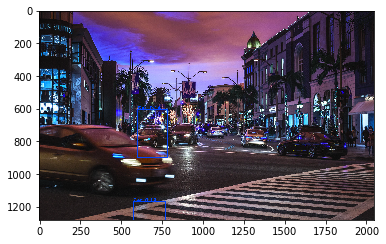

In [73]:
'bike': (0, 255, 255), 'car': (0, 69, 255), 'pedestrian': (0, 255, 0), 
                       'signal': (255, 144, 30), 'truck': (130, 0, 75)

### Detector Scratch

In [42]:
weights_path = './MobileNetV2_YoloV3.pth'

# Create model
model = YOLOv3Layer(params)

# Load weights
model.load_state_dict(torch.load(weights_path))

# Moves all model parameters and buffers to the CPU
model = model.cpu()

In [43]:
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

# Colors: HSV to RGB
hsv_tuples = [(c/model.n_classes, 1., 1.) for c in range(model.n_classes)]
print(hsv_tuples)

[(0.0, 1.0, 1.0), (0.2, 1.0, 1.0), (0.4, 1.0, 1.0), (0.6, 1.0, 1.0), (0.8, 1.0, 1.0)]


In [44]:
import colorsys
colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv_tuples))
print(colors)

[(1.0, 0.0, 0.0), (0.7999999999999998, 1.0, 0.0), (0.0, 1.0, 0.40000000000000036), (0.0, 0.40000000000000036, 1.0), (0.8000000000000007, 0.0, 1.0)]


In [45]:
colors = list(map(lambda c: (int(c[0] * 255), int(c[1] * 255), int(c[2] * 255)), colors))
print(colors)

[(255, 0, 0), (203, 255, 0), (0, 255, 102), (0, 102, 255), (204, 0, 255)]


In [46]:
import matplotlib.pyplot as plt

In [47]:
# Read image
image_path = './example.jpg'
image = cv2.imread(image_path)
image.shape

(1280, 2048, 3)

In [48]:
# Resize image and preserve aspect ration
input_size = (416, 416)
lb_image = letterbox_image(image, size=tuple(reversed(input_size)))
print(lb_image.size)

(416, 416)


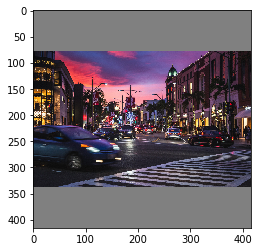

In [49]:
# Convert PIL.Image.Image to NumPy array and covert resulting array to [0, 1]
image_data = np.array(lb_image, dtype=np.float32)/255.0
plt.imshow(image_data)

In [50]:
# Convert NumPy array to PyTorch tensor
img = torch.from_numpy(image_data)
print(img.shape)

torch.Size([416, 416, 3])


In [51]:
# Add dimension for batch
img = img.unsqueeze(0)
print(img.shape)

torch.Size([1, 416, 416, 3])


In [52]:
# bs x W x H x C -> bs x C x W x H
img = img.view(img.size(0), img.size(1), img.size(2), img.size(3))
img = img.permute(0, 3, 1, 2).contiguous()
print(img.shape)

torch.Size([1, 3, 416, 416])


In [53]:
# Original image shape for correcting bounding boxes (PyTorch tensor)
img_shape = torch.Tensor([image.shape[0], image.shape[1]])
print(img_shape)

tensor([1280., 2048.])


In [54]:
# Detect, NOTE: score_threshold is set to 0.1 for development, change to 0.5 or higher
dets, img_indices, classes = model.detect(img, img_shape)
print(dets)

tensor([[ 602.6714,  606.2286,  783.7816,  900.4168,    0.1426],
        [ 576.4055, 1168.4734,  773.3643, 1451.4011,    0.1224]])


In [55]:
# Convert PyTorch tensors to NumPy arrays
dets = dets.numpy()
img_indices = img_indices.numpy()
classes = classes.numpy()

print(dets)
print(img_indices)
print(classes)

[[6.02671387e+02 6.06228577e+02 7.83781616e+02 9.00416809e+02
  1.42639711e-01]
 [5.76405457e+02 1.16847339e+03 7.73364258e+02 1.45140112e+03
  1.22351296e-01]]
[0. 0.]
[1. 1.]


car
car


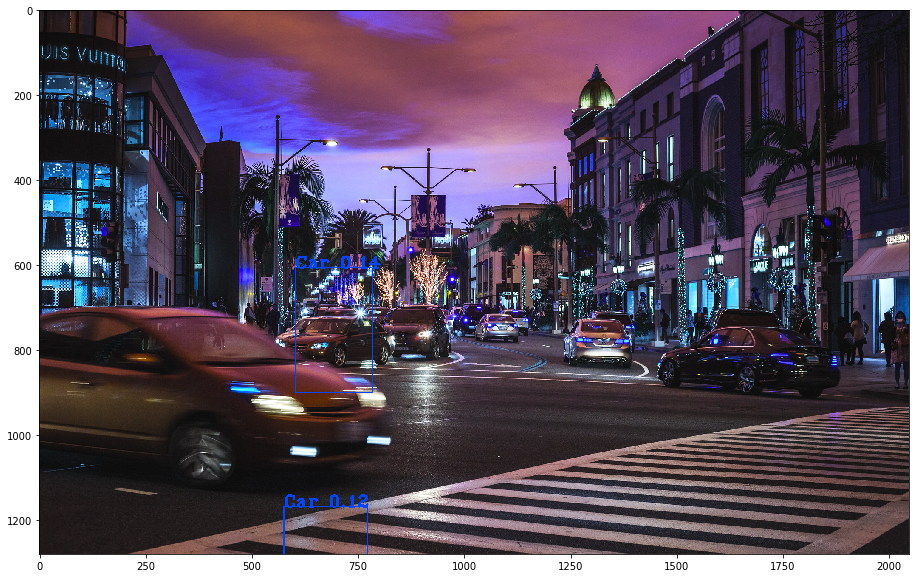

In [75]:
# Draw bounding boxes on image
image = cv2.imread(image_path)
colors = {'bike': (0, 255, 255), 'car': (0, 69, 255), 'pedestrian': (0, 255, 0), 
          'signal': (255, 144, 30), 'truck': (130, 0, 75)}

for i, c in enumerate(classes):
    predicted_class = model.params.class_map[int(c)]
    print(predicted_class)
    bbox = dets[i]
    x_min, y_min, x_max, y_max, score = bbox
    label = '{} {:.2f}'.format(predicted_class.title(), score)
    
    # Make sure the min and max coordinates are within image boundary
    x_min = max(0, np.floor(x_min + 0.5).astype(np.int32))
    y_min = max(0, np.floor(y_min + 0.5).astype(np.int32))
    x_max = min(image.shape[1], np.floor(x_max + 0.5).astype(np.int32))
    y_max = min(image.shape[0], np.floor(y_max + 0.5).astype(np.int32))
    
    image = cv2.rectangle(image.copy(), (x_min, y_min), (x_max, y_max), colors[predicted_class], 2)
    image = cv2.putText(image.copy(), label, (x_min, y_min), fontFace=5, fontScale=2, 
                        color=colors[predicted_class], thickness=3)

plt.figure(figsize=(20,10))
plt.imshow(image)

In [ ]:
# Write image
cv2.imwrite("./detection.jpeg", image)